In [1]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa


/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [3]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [4]:
OUTPUT_DIR = os.path.join('..', 'models', 'timit-xlsr-finetune-B')
PRE_TRAINED_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"

# Load Data

In [5]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [6]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))
test_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TEST'), timit_files))))

In [7]:

def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            timestamped_phonemes.append((timit2ipa(phoneme, "eng"), int(start), int(end)))
    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}
    

In [8]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

In [9]:

parsed_0 = timit_file_to_dict(training_files[0])
print(parsed_0)

{'timestamped_phonemes': [('', 0, 2610), ('', 2610, 3910), ('l', 3910, 4595), ('æ', 4595, 7400), ('s', 7400, 9520), ('ð', 9520, 11090), ('ə', 11090, 12090), ('s', 12090, 14200), ('k', 14200, 14790), ('', 14790, 15490), ('ɹ', 15490, 17211), ('ʉ', 17211, 20762), ('ʔ', 20762, 22198), ('ɨ', 22198, 23310), ('n', 23310, 24123), ('j', 24123, 24772), ('ɚ', 24772, 26109), ('l', 26109, 27237), ('ɛ', 27237, 29400), ('f', 29400, 30680), ('t', 30680, 31000), ('', 31000, 31540), ('h', 31540, 32290), ('æ', 32290, 34840), ('n', 34840, 35800), ('d', 35800, 37739), ('', 37739, 39680)], 'wav_filename': 'data/TRAIN/DR5/MSAS0/SX116.WAV'}


In [10]:
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

In [11]:
train_df = files_to_df(training_files)
train_df.head()

,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",læsðəskɹʉʔɨnjɚlɛfthænd,"[0, 2610, 3910, 4595, 7400, 9520, 11090, 12090...","[2610, 3910, 4595, 7400, 9520, 11090, 12090, 1..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",wʌɾ̃əvðəmoʊstɨzaɪɚbl̩ fittʃɚʒfɝpɑɹkɚbjʉɾɨfl̩ v...,"[0, 2040, 2622, 3174, 3592, 4386, 4929, 5270, ...","[2040, 2622, 3174, 3592, 4386, 4929, 5270, 584..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðəhɔlweɪʔoʊpn̩zɨntə̥wɨhjʉddʒttʃeɪmbɚ,"[0, 2161, 2530, 3097, 4650, 6226, 7160, 8020, ...","[2161, 2530, 3097, 4650, 6226, 7160, 8020, 964..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʌsɔpaɪnɹizɨnɹɛdwʊdzʔɔnɦɨzwɔkθɹʉsɨkɔɪɨnæʃn̩l̩ f...,"[0, 2208, 2592, 4565, 6570, 8920, 10067, 10880...","[2208, 2592, 4565, 6570, 8920, 10067, 10880, 1..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",noʊwiddʒɨnswɛɾɝzɚmeɪdʌvlæmzwoʊl,"[0, 1814, 2400, 3968, 5376, 6913, 7561, 8080, ...","[1814, 2400, 3968, 5376, 6913, 7561, 8080, 881..."


In [12]:
test_df = files_to_df(test_files)
test_df.head()

,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊnæsmiɾɨkɛɹin̩ɔɪliɹæglaɪkðæt,"[0, 3560, 4040, 5880, 6440, 8600, 9852, 10280,...","[3560, 4040, 5880, 6440, 8600, 9852, 10280, 10..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ɛstsl̩ ʉʃɨnɪztɨfaɪɾ̃ənɛɹiəðɛɾɪzpɚdɑmənʔlisʌnla...,"[0, 2233, 2427, 4708, 6642, 7153, 8355, 9119, ...","[2233, 2427, 4708, 6642, 7153, 8355, 9119, 114..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",dʒeɪnmeɪʔɝnmɔɹmʌɾ̃ibaɪwɝkɨŋɦɑɹd,"[0, 2040, 3240, 7488, 8647, 9156, 11070, 13163...","[2040, 3240, 7488, 8647, 9156, 11070, 13163, 1..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʌpstɛɚzbɪzɨfitʃaʊɚɨŋlaɪkɹeɪndɹɑpsæɾɚdɚɹaʊndɦɚɹum,"[0, 9176, 10061, 11363, 11784, 13409, 14220, 1...","[9176, 10061, 11363, 11784, 13409, 14220, 1456..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊnæskmiɾɨkæɹiɨnɔɪliɹæglaɪkðæt,"[0, 2200, 2590, 4261, 5138, 7480, 8740, 9712, ...","[2200, 2590, 4261, 5138, 7480, 8740, 9712, 104..."


### Cleaning Up Audio

In [13]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

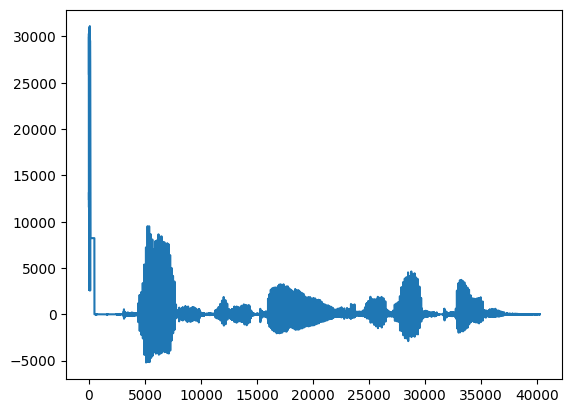

In [14]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(train_df['audio'][0])
plt.show()

In [15]:
# Apply the process_row function to each row in the DataFrame
train_df['cropped_audio'] = train_df.apply(crop_audio, axis=1) 
train_df.head()
    

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",læsðəskɹʉʔɨnjɚlɛfthænd,"[0, 2610, 3910, 4595, 7400, 9520, 11090, 12090...","[2610, 3910, 4595, 7400, 9520, 11090, 12090, 1...","[1, -2, 0, -3, 2, 2, 0, -1, 2, -1, 1, 3, -1, 0..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",wʌɾ̃əvðəmoʊstɨzaɪɚbl̩ fittʃɚʒfɝpɑɹkɚbjʉɾɨfl̩ v...,"[0, 2040, 2622, 3174, 3592, 4386, 4929, 5270, ...","[2040, 2622, 3174, 3592, 4386, 4929, 5270, 584...","[4, 3, 1, 3, 4, 3, 2, 3, 4, 3, 3, 3, 1, 5, 0, ..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðəhɔlweɪʔoʊpn̩zɨntə̥wɨhjʉddʒttʃeɪmbɚ,"[0, 2161, 2530, 3097, 4650, 6226, 7160, 8020, ...","[2161, 2530, 3097, 4650, 6226, 7160, 8020, 964...","[-4, -1, -2, -1, 4, -1, -3, 4, 0, 0, 2, 5, 4, ..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʌsɔpaɪnɹizɨnɹɛdwʊdzʔɔnɦɨzwɔkθɹʉsɨkɔɪɨnæʃn̩l̩ f...,"[0, 2208, 2592, 4565, 6570, 8920, 10067, 10880...","[2208, 2592, 4565, 6570, 8920, 10067, 10880, 1...","[1, 1, 0, 11, -3, 4, -2, 1, 7, 5, 8, -1, -6, -..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",noʊwiddʒɨnswɛɾɝzɚmeɪdʌvlæmzwoʊl,"[0, 1814, 2400, 3968, 5376, 6913, 7561, 8080, ...","[1814, 2400, 3968, 5376, 6913, 7561, 8080, 881...","[-1, 1, 4, 4, 5, 6, 0, -2, 3, 5, 5, 3, 0, -2, ..."


In [16]:
test_df['cropped_audio'] = test_df.apply(crop_audio, axis=1)
test_df.head()

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊnæsmiɾɨkɛɹin̩ɔɪliɹæglaɪkðæt,"[0, 3560, 4040, 5880, 6440, 8600, 9852, 10280,...","[3560, 4040, 5880, 6440, 8600, 9852, 10280, 10...","[0, 1, 0, 2, 3, -1, 0, 2, 2, 0, 1, 0, 2, 0, 1,..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ɛstsl̩ ʉʃɨnɪztɨfaɪɾ̃ənɛɹiəðɛɾɪzpɚdɑmənʔlisʌnla...,"[0, 2233, 2427, 4708, 6642, 7153, 8355, 9119, ...","[2233, 2427, 4708, 6642, 7153, 8355, 9119, 114...","[-6, -5, -8, -10, -15, -17, -18, -21, -21, -22..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",dʒeɪnmeɪʔɝnmɔɹmʌɾ̃ibaɪwɝkɨŋɦɑɹd,"[0, 2040, 3240, 7488, 8647, 9156, 11070, 13163...","[2040, 3240, 7488, 8647, 9156, 11070, 13163, 1...","[3, 0, 4, 0, 2, 0, 1, 0, 2, 0, 1, 2, 1, 0, 3, ..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʌpstɛɚzbɪzɨfitʃaʊɚɨŋlaɪkɹeɪndɹɑpsæɾɚdɚɹaʊndɦɚɹum,"[0, 9176, 10061, 11363, 11784, 13409, 14220, 1...","[9176, 10061, 11363, 11784, 13409, 14220, 1456...","[0, 0, 5, 4, 5, 0, 2, 2, 4, 1, -1, 0, 1, 2, 5,..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊnæskmiɾɨkæɹiɨnɔɪliɹæglaɪkðæt,"[0, 2200, 2590, 4261, 5138, 7480, 8740, 9712, ...","[2200, 2590, 4261, 5138, 7480, 8740, 9712, 104...","[0, 2, 3, 0, 3, -1, 0, 1, 2, -2, 1, 2, 3, 2, 2..."


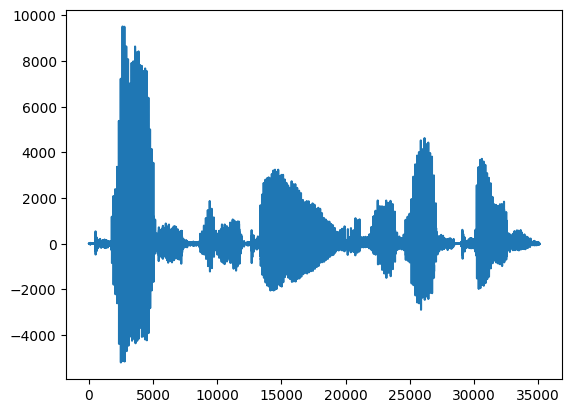

In [17]:
# visualize again, much better!
plt.plot(train_df['cropped_audio'][0])


In [18]:
# train_df comprised of just cropped_audio and phonemes
train_df = train_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
# rename cropped audio to audio
train_df = train_df.rename(columns={'cropped_audio': 'audio'})
train_df.head()

,ipa,audio
0,læsðəskɹʉʔɨnjɚlɛfthænd,"[1, -2, 0, -3, 2, 2, 0, -1, 2, -1, 1, 3, -1, 0..."
1,wʌɾ̃əvðəmoʊstɨzaɪɚbl̩ fittʃɚʒfɝpɑɹkɚbjʉɾɨfl̩ v...,"[4, 3, 1, 3, 4, 3, 2, 3, 4, 3, 3, 3, 1, 5, 0, ..."
2,ðəhɔlweɪʔoʊpn̩zɨntə̥wɨhjʉddʒttʃeɪmbɚ,"[-4, -1, -2, -1, 4, -1, -3, 4, 0, 0, 2, 5, 4, ..."
3,ʌsɔpaɪnɹizɨnɹɛdwʊdzʔɔnɦɨzwɔkθɹʉsɨkɔɪɨnæʃn̩l̩ f...,"[1, 1, 0, 11, -3, 4, -2, 1, 7, 5, 8, -1, -6, -..."
4,noʊwiddʒɨnswɛɾɝzɚmeɪdʌvlæmzwoʊl,"[-1, 1, 4, 4, 5, 6, 0, -2, 3, 5, 5, 3, 0, -2, ..."


In [19]:
# Same for test_df
test_df = test_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
test_df = test_df.rename(columns={'cropped_audio': 'audio'})
test_df.head()

,ipa,audio
0,oʊnæsmiɾɨkɛɹin̩ɔɪliɹæglaɪkðæt,"[0, 1, 0, 2, 3, -1, 0, 2, 2, 0, 1, 0, 2, 0, 1,..."
1,ɛstsl̩ ʉʃɨnɪztɨfaɪɾ̃ənɛɹiəðɛɾɪzpɚdɑmənʔlisʌnla...,"[-6, -5, -8, -10, -15, -17, -18, -21, -21, -22..."
2,dʒeɪnmeɪʔɝnmɔɹmʌɾ̃ibaɪwɝkɨŋɦɑɹd,"[3, 0, 4, 0, 2, 0, 1, 0, 2, 0, 1, 2, 1, 0, 3, ..."
3,ʌpstɛɚzbɪzɨfitʃaʊɚɨŋlaɪkɹeɪndɹɑpsæɾɚdɚɹaʊndɦɚɹum,"[0, 0, 5, 4, 5, 0, 2, 2, 4, 1, -1, 0, 1, 2, 5,..."
4,oʊnæskmiɾɨkæɹiɨnɔɪliɹæglaɪkðæt,"[0, 2, 3, 0, 3, -1, 0, 1, 2, -2, 1, 2, 3, 2, 2..."


In [20]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# Extend Phoneme Vocab

In [21]:
timit_vocab = set("".join(train_df['ipa'])) | set("".join(test_df['ipa']))

In [16]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()

In [23]:
additional_vocab = timit_vocab.difference(set(vocab.keys()) | {' '})
tokenizer.add_tokens(list(additional_vocab))
print(additional_vocab)

{'̃', '̥', '̩', '̍', 'ɝ', 'g', 'ɦ'}


In [24]:
# replace ' ' in ipa with tokenizer.pad_token
train_ds = train_ds.map(lambda x: {'audio': x['audio'], 'ipa': x['ipa'].replace(' ', tokenizer.pad_token)})
test_ds = test_ds.map(lambda x: {'audio': x['audio'], 'ipa': x['ipa'].replace(' ', tokenizer.pad_token)})

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map: 100%|██████████| 1680/1680 [00:37<00:00, 45.18 examples/s]


# Update Feature Extraction

In [18]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

# Save Updated Tokenizer and Feature Extractor

In [19]:
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
processor.tokenizer = tokenizer
processor.feature_extractor = feature_extractor
processor.save_pretrained(OUTPUT_DIR)

[]

# Preprocess Data

In [27]:
def prepare_dataset(batch):
    batch["input_values"] = processor(batch["audio"], sampling_rate=feature_extractor.sampling_rate).input_values
    batch["labels"] = processor(text=batch["ipa"]).input_ids
    return batch

In [28]:
train_ds_prepared = train_ds.map(prepare_dataset, batch_size=8, num_proc=1, batched=True)

Map:  47%|████▋     | 2192/4620 [00:53<00:57, 42.13 examples/s]

Map: 100%|██████████| 4620/4620 [01:53<00:00, 40.66 examples/s]


In [29]:
test_ds_prepared = test_ds.map(prepare_dataset, batch_size=8, num_proc=4, batched=True)

Map (num_proc=4):   0%|          | 0/1680 [00:00<?, ? examples/s]

Map (num_proc=4): 100%|██████████| 1680/1680 [00:29<00:00, 56.77 examples/s]


In [30]:
train_ds_prepared.to_pandas().head()

,ipa,audio,input_values,labels
0,læsðəskɹʉʔɨnjɚlɛfthænd,"[1, -2, 0, -3, 2, 2, 0, -1, 2, -1, 1, 3, -1, 0...","[0.0017016534013310205, -0.0022890036596434835...","[14, 8, 8, 17, 35, 20, 66, 43, 44, 30, 14, 5, ..."
1,wʌɾ̃əvðəmoʊstɨzaɪɚbl̩<pad>fittʃɚʒfɝpɑɹkɚbjʉɾɨf...,"[4, 3, 1, 3, 4, 3, 2, 3, 4, 3, 3, 3, 1, 5, 0, ...","[0.012731370951819221, 0.009804374123075704, 0...","[12, 33, 26, 61, 24, 46, 6, 63, 4, 12, 25, 30,..."
2,ðəhɔlweɪʔoʊpn̩zɨntə̥wɨhjʉddʒttʃeɪmbɚ,"[-4, -1, -2, -1, 4, -1, -3, 4, 0, 0, 2, 5, 4, ...","[-0.008398369035976105, -0.0009453301643612678...","[14, 22, 38, 32, 41, 44, 66, 49, 18, 7, 4, 67,..."
3,ʌsɔpaɪnɹizɨnɹɛdwʊdzʔɔnɦɨzwɔkθɹʉsɨkɔɪɨnæʃn̩l̩<p...,"[1, 1, 0, 11, -3, 4, -2, 1, 7, 5, 8, -1, -6, -...","[0.0036830549221775334, 0.0036830549221775334,...","[6, 63, 4, 12, 25, 30, 14, 5, 49, 18, 7, 4, 67..."
4,noʊwiddʒɨnswɛɾɝzɚmeɪdʌvlæmzwoʊl,"[-1, 1, 4, 4, 5, 6, 0, -2, 3, 5, 5, 3, 0, -2, ...","[-0.0039456422072584145, 0.004728759004920471,...","[14, 4, 49, 8, 14, 15, 43, 6, 46, 44, 6, 44, 1..."


# Fine-Tune Model

In [10]:
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    def __init__(self, processor: AutoProcessor, padding=True, max_length=None, max_length_labels=None, pad_to_multiple_of=None, pad_to_multiple_of_labels=None):
        self.processor = processor
        self.padding = padding
        self.max_length = max_length
        self.max_length_labels = max_length_labels
        self.pad_to_multiple_of = pad_to_multiple_of
        self.pad_to_multiple_of_labels = pad_to_multiple_of_labels

    def __call__(self, features: "list[dict[str, list[int] | torch.Tensor]]") -> "dict[str, torch.Tensor]":
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [11]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

NameError: name 'processor' is not defined

In [33]:
def cer(pred, label):
    distances = np.zeros((len(pred) + 1, len(label) + 1))

    for t1 in range(len(pred) + 1):
        distances[t1][0] = t1

    for t2 in range(len(label) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(pred) + 1):
        for t2 in range(1, len(label) + 1):
            if (pred[t1-1] == label[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(pred)][len(label)] / len(label)

In [34]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False) # labels are already grouped as they should be

    err = cer(pred_str, label_str)

    return {"cer": err}

In [20]:
model = AutoModelForCTC.from_pretrained(
    PRE_TRAINED_ID, 
    pad_token_id=processor.tokenizer.pad_token_id, 
    # gradient_checkpointing=True,
    ctc_zero_infinity = True
)

In [36]:
# model.resize_token_embeddings(len(tokenizer))
old_weights = model.lm_head.weight.t().detach()
old_bias = model.lm_head.bias.detach()
new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
new_layer.weight.data[:model.lm_head.out_features, :] = old_weights.t()
new_layer.bias.data[:model.lm_head.out_features] = old_bias
model.lm_head = new_layer
model.config.vocab_size = len(processor.tokenizer)

In [37]:
model.freeze_feature_encoder()

In [38]:
# sanity checks
max_class_id = 0
for label_sequence in train_ds_prepared['labels']:
    for class_id in label_sequence:
        max_class_id = max(max_class_id, class_id)
assert max_class_id == model.config.vocab_size - 1

for label_sequence in train_ds_prepared['labels']:
    for class_id in label_sequence:
        assert class_id >= 0 and class_id <  model.config.vocab_size

for label_sequence in train_ds_prepared['labels']:
    assert  len(label_sequence) < 1024
    assert len(label_sequence) >= 5

In [39]:
import wandb
from transformers import TrainingArguments, Trainer

# Initialize wandb
wandb.init(project="timit-finetune")

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    group_by_length=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    eval_strategy="steps",
    num_train_epochs=150,
    fp16=True,
    save_steps=50,
    eval_steps=50,
    logging_steps=10,
    learning_rate=1e-7,
    warmup_steps=1000,
    save_total_limit=3,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    max_grad_norm=1.0,
    report_to="wandb" 
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aruna-sri (aruna-team). Use `wandb login --relogin` to force relogin


In [40]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds_prepared.select(range(200)),
    # train_dataset=train_ds_prepared,
    eval_dataset=test_ds_prepared.select(range(200)),
    # eval_dataset=test_ds_prepared,
    processing_class=processor.feature_extractor,
)

In [41]:
torch.autograd.set_detect_anomaly(False) # debug NaNs, disable for real training to improve performance
# model.config.ctc_zero_infinity = True 
trainer.train() # resume_from_checkpoint=True to resume training if training was interrupted

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer 

TrainOutput(global_step=600, training_loss=7840.953720703125, metrics={'train_runtime': 1325.4353, 'train_samples_per_second': 16.976, 'train_steps_per_second': 0.453, 'total_flos': 1.79283514318251e+18, 'train_loss': 7840.953720703125, 'epoch': 133.31578947368422})

# Evaluate

In [42]:
import wandb
eval_results = trainer.evaluate()
wandb.log(eval_results)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [8]:
old_model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID).to(model.device)

NameError: name 'model' is not defined

In [24]:
finetuned_model = AutoModelForCTC.from_pretrained(os.path.join(OUTPUT_DIR, 'checkpoint-1000'))

In [25]:
# check for nan weights and replace with old values if any
for name, param in finetuned_model.named_parameters():
    if torch.isnan(param).any():
        print(name)
        param.data = old_model.state_dict()[name].data

In [26]:
# compare weights
is_diff = False
for name, param in finetuned_model.named_parameters():
    if not torch.equal(param, old_model.state_dict()[name].to(finetuned_model.device)):
        is_diff = True
        break
print("Weights are different, training did something" if is_diff else "Weights are the same, training did nothing")

NameError: name 'old_model' is not defined

In [27]:
def predict(model, wav_file):
    speech = audio_file_to_array(wav_file)
    input_values = processor(speech, sampling_rate=16000, return_tensors="pt").input_values.type(torch.float32).to(model.device)

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])
    

In [28]:
print('Checkpoint Transcription:', predict(finetuned_model, os.path.join('..', 'data', 'alexIsConfused.wav')))

Checkpoint Transcription: eɪ l ɾ t eɪ t l ɛ s m k ɛ s l p k aɪ s l æ aɪ k ɛ t n d k eɪ ʃ v b ɛ n ɛ f eɪ j b b aɪ b ɛ t iː


In [ ]:
print('Best Fine-Tune Transcription:', predict(trainer.model, os.path.join('..', 'data', 'alexIsConfused.wav')))

In [23]:
print('Best Fine-Tune Transcription:', predict(trainer.model, os.path.join('..', 'data', 'alexIsConfused.wav')))

NameError: name 'trainer' is not defined

In [76]:
print('Old Transcription:', predict(old_model, os.path.join('..', 'data', 'alexIsConfused.wav')))

Old Transcription: h ɛ l oʊ æ l ɪ k s ɪ z ɛ k s t ɾ ɹ ə k ə n f iː l ʊ s t


In [45]:
import wandb

sweep_config = {
    'method': 'bayes',  # Or 'grid' or 'random'
    'metric': {'name': 'loss', 'goal': 'minimize'},
    'parameters': {
        'learning_rate': {'min': 1e-8, 'max': 5e-6, 'distribution': 'log_uniform_values'},
        'per_device_train_batch_size': {'values': [4, 8, 16]},
        'num_train_epochs': {'values': [3, 5, 10]},
    }
}

sweep_id = wandb.sweep(sweep_config, project="timit-finetune-hyperparam")

from transformers import TrainingArguments, Trainer

def train():
    # Initialize a new wandb run
    wandb.init()

    # Set up training arguments, pulling values from wandb.config
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        group_by_length=True,
        per_device_train_batch_size=wandb.config.per_device_train_batch_size,
        gradient_accumulation_steps=4,
        eval_strategy="steps",
        num_train_epochs=wandb.config.num_train_epochs,
        fp16=True,
        save_steps=50,
        eval_steps=50,
        logging_steps=10,
        learning_rate=wandb.config.learning_rate,
        warmup_steps=1000,
        save_total_limit=3,
        gradient_checkpointing=True,
        load_best_model_at_end=True,
        max_grad_norm=1.0,
        report_to="wandb"
    )

    trainer = Trainer(
        model=model,
        data_collator=data_collator,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_ds_prepared,
        eval_dataset=test_ds_prepared,
        processing_class=processor.feature_extractor,
    )

    # Run training and automatically log results to W&B
    trainer.train()

    # Ensure to log any additional evaluation metrics
    eval_metrics = trainer.evaluate()
    wandb.log(eval_metrics)



wandb.agent(sweep_id, train, count=5)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: b2pxzie9
Sweep URL: https://wandb.ai/aruna-team/timit-finetune-hyperparam/sweeps/b2pxzie9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j69zyxg1 with config:
wandb: 	learning_rate: 1.9100852568813272e-08
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 4


wandb: 🚀 View run vibrant-pyramid-9 at: https://wandb.ai/aruna-team/timit-finetune/runs/h93avd58
wandb: Find logs at: wandb/run-20241115_045627-h93avd58/logs


wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Cer
50,2126.116800,2166.366211,1.000000
100,1907.205700,2166.355469,1.000000
150,2107.934800,2166.327393,1.000000
200,1952.314600,2166.268555,1.000000
250,1939.089300,2166.171143,1.000000
300,7263.468000,2166.041992,1.000000
350,6529.998000,2165.866699,1.000000
400,6916.693800,2165.670166,1.000000
450,7391.245300,2165.394775,1.000000
500,6652.000800,2165.065430,1.000000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer 

epoch,▁
eval/cer,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,██████▇▇▇▆▆▅▄▄▃▂▁▁
eval/runtime,▄▃▄▂▁▃▁▁▂▃▅▂▆▅█▅█▃
eval/samples_per_second,▅▆▄▇█▆██▇▆▄▇▃▄▁▄▁▆
eval/steps_per_second,▅▆▄▇█▆██▇▆▄▇▃▄▁▄▁▆
eval_cer,▁
eval_loss,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


wandb: Agent Starting Run: 93qrmgzh with config:
wandb: 	learning_rate: 1.670512733589786e-06
wandb: 	num_train_epochs: 10
wandb: 	per_device_train_batch_size: 4


wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Cer
50,2124.236500,2160.302490,1.000000
100,1905.107800,2156.335449,1.000000
150,2103.522900,2149.275879,1.000000
200,1944.339100,2141.821533,1.000000
250,1935.538900,2135.632080,1.000000
300,7223.684400,2130.099609,1.000000
350,6485.108200,2125.869385,1.000000
400,6841.821100,2121.018066,1.000000
450,7304.120300,2116.460938,1.000000
500,6586.377300,2111.827148,1.000000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer 

In [58]:
import wandb
import optuna
from transformers import TrainingArguments, Trainer

# Initialize wandb
wandb.init(project="hyperparam")

def model_init():
    return model

def objective(trial):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-8, 1e-7, log=True)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [2, 4, 8])
    num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 15)

    # Update training arguments with dynamic hyperparameters
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        run_name="hyperparam-searchC",  # Set a unique run name
        group_by_length=True,
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=4,
        evaluation_strategy="steps",
        num_train_epochs=num_train_epochs,
        fp16=True,
        save_steps=100,
        eval_steps=100,
        logging_steps=100,
        learning_rate=learning_rate,
        warmup_steps=1000,
        save_total_limit=3,
        gradient_checkpointing=True,
        load_best_model_at_end=True,
        max_grad_norm=1.0,
        report_to="wandb"  # Report to WandB
    )

    # Set up the trainer with the training arguments and datasets
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        train_dataset=train_ds_prepared.select(range(100)),  # Use a subset for faster experimentation
        eval_dataset=test_ds_prepared.select(range(100)),
        processing_class=processor.feature_extractor,
    )

    # Disable anomaly detection for better performance
    torch.autograd.set_detect_anomaly(False)
    # model.config.ctc_zero_infinity = True  # Uncomment if needed for CTC models

    # Train the model for this trial
    result = trainer.train()  # Set resume_from_checkpoint=True if resuming is required

    # Return the final training loss for Optuna to minimize
    return result.training_loss

# Perform hyperparameter search with updated search space
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-11-14 19:06:16,626] A new study created in memory with name: no-name-4f36681b-7de1-48b5-82a9-e3e4641bccb6
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecate

Step,Training Loss,Validation Loss


[I 2024-11-14 19:07:09,061] Trial 0 finished with value: 4984.161979166666 and parameters: {'learning_rate': 7.687952860086006e-07, 'per_device_train_batch_size': 4, 'num_train_epochs': 5}. Best is trial 0 with value: 4984.161979166666.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/pytho

Step,Training Loss,Validation Loss


[I 2024-11-14 19:08:01,943] Trial 1 finished with value: 4984.1171875 and parameters: {'learning_rate': 5.973695659770477e-07, 'per_device_train_batch_size': 4, 'num_train_epochs': 5}. Best is trial 1 with value: 4984.1171875.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-

Step,Training Loss,Validation Loss


[I 2024-11-14 19:08:55,255] Trial 2 finished with value: 4984.077604166667 and parameters: {'learning_rate': 1.493259017726814e-06, 'per_device_train_batch_size': 4, 'num_train_epochs': 5}. Best is trial 2 with value: 4984.077604166667.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/pytho

Step,Training Loss,Validation Loss


[I 2024-11-14 19:09:59,119] Trial 3 finished with value: 2519.1041666666665 and parameters: {'learning_rate': 3.2132405085015246e-07, 'per_device_train_batch_size': 2, 'num_train_epochs': 5}. Best is trial 3 with value: 2519.1041666666665.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/py

Step,Training Loss,Validation Loss


[I 2024-11-14 19:11:07,802] Trial 4 finished with value: 2519.0208333333335 and parameters: {'learning_rate': 2.0615922759934747e-06, 'per_device_train_batch_size': 2, 'num_train_epochs': 5}. Best is trial 4 with value: 2519.0208333333335.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/py

Step,Training Loss,Validation Loss


[I 2024-11-14 19:11:55,215] Trial 5 finished with value: 9643.107291666667 and parameters: {'learning_rate': 1.0927644338378763e-07, 'per_device_train_batch_size': 8, 'num_train_epochs': 5}. Best is trial 4 with value: 2519.0208333333335.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/pyt

Step,Training Loss,Validation Loss


[I 2024-11-14 19:12:48,126] Trial 6 finished with value: 4983.488020833333 and parameters: {'learning_rate': 5.935061857451671e-06, 'per_device_train_batch_size': 4, 'num_train_epochs': 5}. Best is trial 4 with value: 2519.0208333333335.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/pyth

Step,Training Loss,Validation Loss


[I 2024-11-14 19:13:56,494] Trial 7 finished with value: 2518.512760416667 and parameters: {'learning_rate': 4.139150701404576e-06, 'per_device_train_batch_size': 2, 'num_train_epochs': 5}. Best is trial 7 with value: 2518.512760416667.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/pytho

Step,Training Loss,Validation Loss


[I 2024-11-14 19:15:05,055] Trial 8 finished with value: 2518.04453125 and parameters: {'learning_rate': 2.0900669738601152e-07, 'per_device_train_batch_size': 2, 'num_train_epochs': 5}. Best is trial 8 with value: 2518.04453125.
/var/tmp/ipykernel_7470/3929815082.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs = trial.suggest_int("num_train_epochs", 5, 10, 20)
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [5, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/si

Step,Training Loss,Validation Loss


[I 2024-11-14 19:15:52,464] Trial 9 finished with value: 9640.767708333333 and parameters: {'learning_rate': 7.006142803301166e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5}. Best is trial 8 with value: 2518.04453125.


Best hyperparameters:  {'learning_rate': 2.0900669738601152e-07, 'per_device_train_batch_size': 2, 'num_train_epochs': 5}
